# Pattern Recognition Course
## Lab 2: Face Recognition

---

## Import Libraries

In [21]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
from IPython.display import Markdown
from PIL import Image
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from scipy.stats import multivariate_normal
from tensorflow import keras
from tensorflow.keras import layers, models

SEED = 42
np.random.seed(SEED)

## Prepare Dataset

- ### Read Images

In [22]:
# Downloading the dataset
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
images = []
labels = []

# Loop through each subject folder (s1 to s40)
for subject in sorted(os.listdir(path)):
    subject_path = os.path.join(path, subject)

    # Skip if not a directory
    if not os.path.isdir(subject_path):
        continue

    # Get the subject number from folder name (s1 -> 0, s2 -> 1, etc.)
    subject_num = int(subject[1:]) - 1

    # Loop through each image in the subject folder
    for image_file in sorted(os.listdir(subject_path)):
        if image_file.endswith('.pgm'):  # AT&T uses PGM format
            image_path = os.path.join(subject_path, image_file)

            # Open and convert to numpy array
            img = Image.open(image_path)
            img_array = np.array(img)

            images.append(img_array)
            labels.append(subject_num)

images, labels = np.array(images), np.array(labels)

print(f"Dataset loaded with {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Number of classes: {len(np.unique(labels))}")

Dataset loaded with 400 images
Image shape: (112, 92)
Number of classes: 40


- ### Generate the Data Matrix

In [23]:
# Calculating number of pixels (features) for each image
row_pixels, col_pixels = images[0].shape
pixels_number = row_pixels * col_pixels

# Initialize data matrix and target vector
X = np.ndarray((len(images), pixels_number))
y = np.array(labels)

# Fill the data matrix
for i, img in enumerate(images):
    X[i] = img.flatten()

print(f'Data Matrix Shape{X.shape}')
print(f'Target Vector Length {y.shape}')

Data Matrix Shape(400, 10304)
Target Vector Length (400,)


- ### Generate Training and Test Sets

In [24]:
# Even rows for testing, Odds for training
X_train, X_test = X[1::2], X[::2]
y_train, y_test = y[1::2], y[::2]
print(f'Training Set Matrix Shape {X_train.shape}, Training Labels Length {y_train.shape}')
print(f'Test Set Matrix Shape {X_test.shape}, Test Labels Length {y_test.shape}')

Training Set Matrix Shape (200, 10304), Training Labels Length (200,)
Test Set Matrix Shape (200, 10304), Test Labels Length (200,)


## Principal Component Analysis

- ### Implementation

In [25]:
# Facilitating an interface for the technique
class PCA:

    # Constructor, needs retained variance percentage and training data
    def __init__(self, alpha):
        # Percentage of total variance to be retained in the model
        self.alpha = alpha
        # Eigenvalues of the covariance matrix (d_features)
        self.eigenvalues = np.array([])
        # Eigenvectors of the covariance matrix (d_features, d_features)
        self.eigenvectors = np.array([[]])
        # Total Variance in the training set
        self.total_variance = 0.0
        # Highest-varianced principal components that retain alpha% of total variance (d_features, k_components)
        self.principal_components = np.array([[]])
        # keeping the empirical mean vector
        self.mean = np.array([])

    def generate_principal_components(self, X):
        """
        Generates the whole set of principal components with their corresponsing eigenvalues.
        Accumulates the total variance of the training set.
        """
        try:
            eigens = np.load('eigen.npz')
            self.eigenvalues, self.eigenvectors = eigens['eigenvalues'], eigens['eigenvectors']
            print("Eigenvalues and eigenvectors are already saved.")
        except FileNotFoundError:
            print("Calculating eigenvectors and eigenvalues for the first time and saving both.")
            cov = np.cov(X, rowvar=False, bias = True)
            self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov)

            # Reverse for descending order
            self.eigenvalues = self.eigenvalues[::-1]
            self.eigenvectors = self.eigenvectors[:, ::-1]
            np.savez('eigen.npz', eigenvalues=self.eigenvalues, eigenvectors=self.eigenvectors)

        self.total_variance = sum(self.eigenvalues)
        print(f"Number of eigenvalues: {self.eigenvalues.shape}")
        print(f"Principal components shape: {self.eigenvectors.shape}")

    def construct_reduced_subspace(self):
        """
        Construct the new PCA subspace with heighest-varianced components
        that retain the required percentage of total variance.
        """
        variance_to_retain = self.alpha * self.total_variance
        retained_variance = 0.0
        k = 0  # Number of components to keep, eigenvetors are sorted based on each's variance

        while retained_variance < variance_to_retain:
            retained_variance += self.eigenvalues[k]
            k += 1

        self.principal_components = self.eigenvectors[:, :k]

    def fit_transform(self, X):
        """
        Returns X_projected: New representation of the data matrix X (n_samples, k_components)
        where k is the number of the heighest-varianced components that retains the required percentage of total variance
        """
        self.generate_principal_components(X)
        self.construct_reduced_subspace()
        self.mean = np.mean(X, axis=0)
        return self.project(X)

    def inverse_transform(self, X_projected):
        """
        Returns the reconstructed data representation of X_projected
        """
        # print(X_projected.shape)
        # print(self.principal_components.T.shape)
        return np.matmul(X_projected, self.principal_components.T) + self.mean

    def project(self, X):
        """
        Returns projection of X into the new subspace
        """
        return np.matmul(X - self.mean, self.principal_components)


- ### Testing with Different Alpha

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>$\alpha$ (Retained Variance) = 0.8</center>

## <center>PCA Subspace Dimensions = 36</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

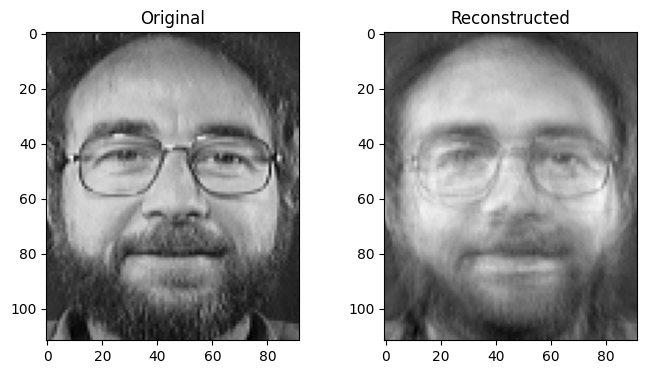

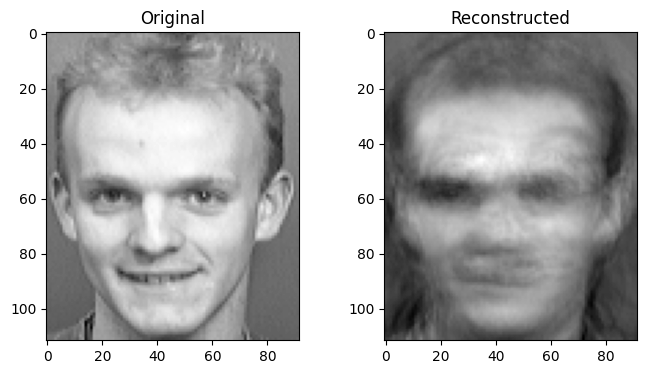

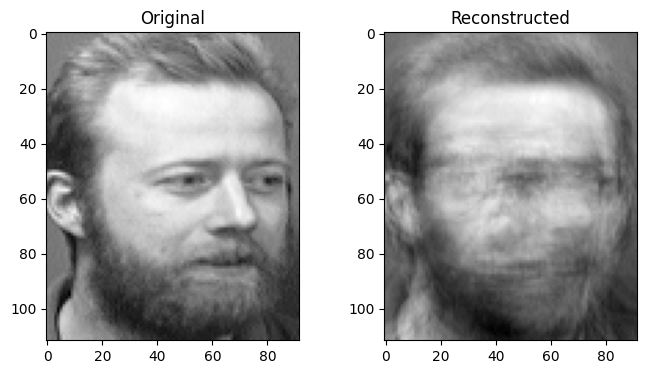

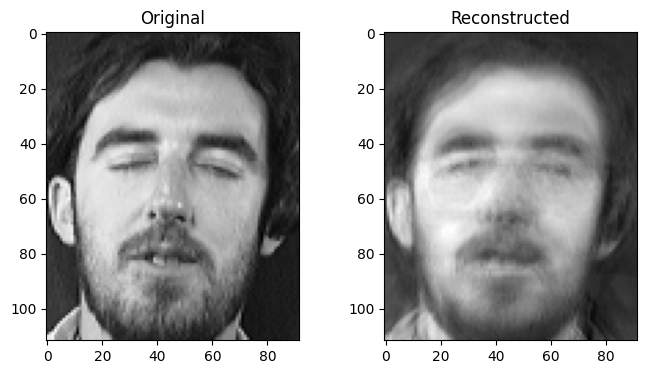

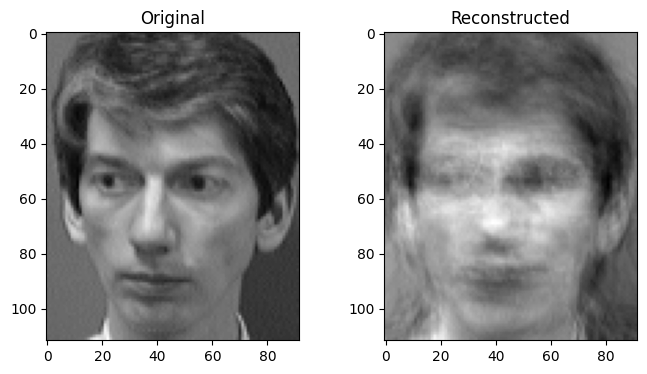

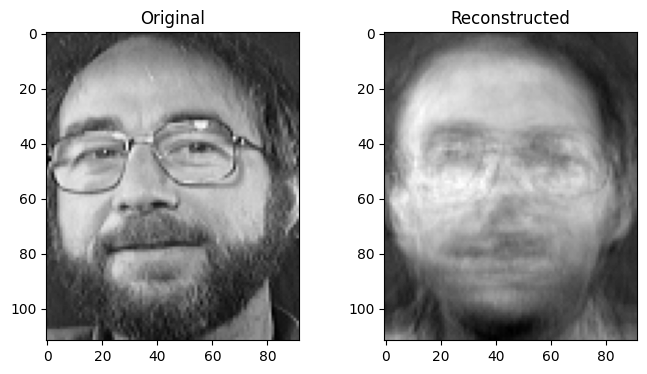

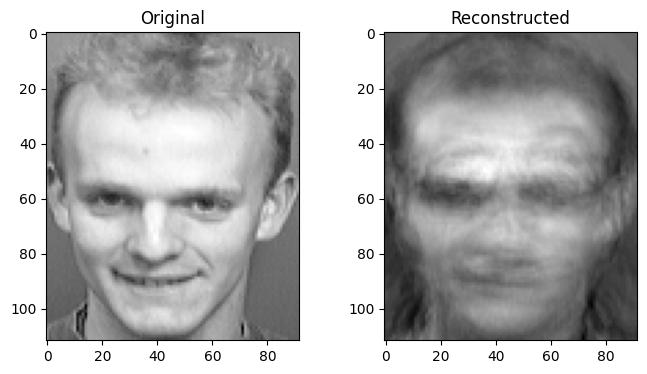

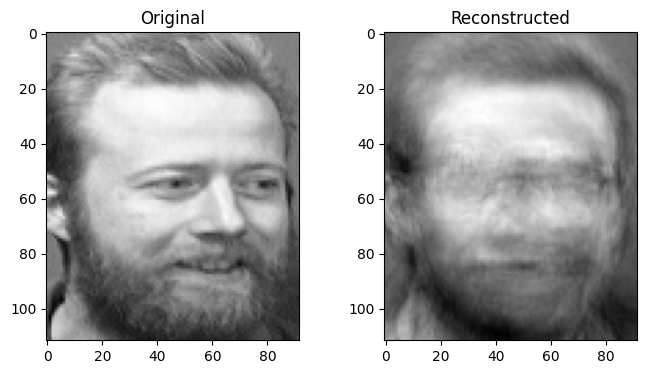

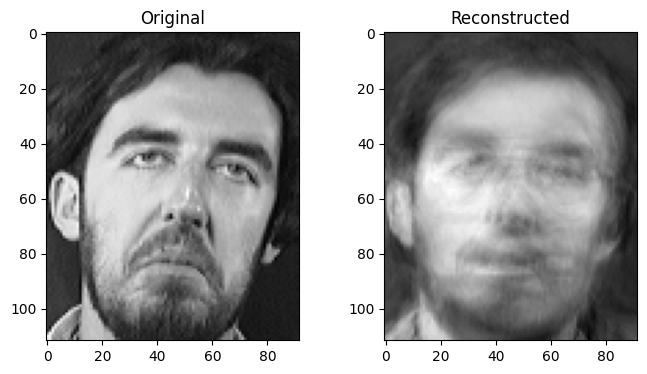

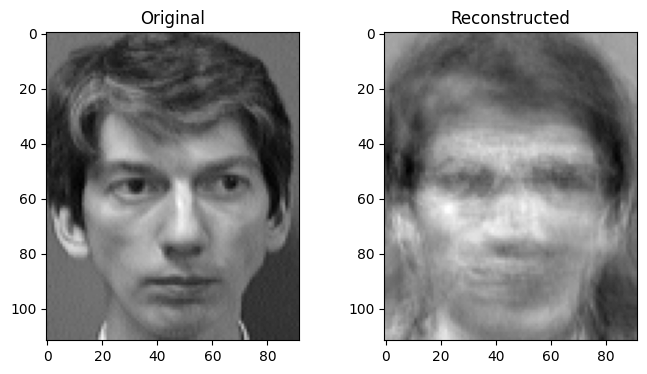

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>$\alpha$ (Retained Variance) = 0.85</center>

## <center>PCA Subspace Dimensions = 52</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

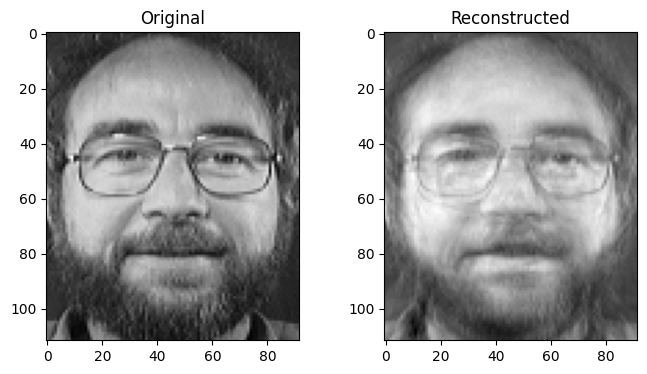

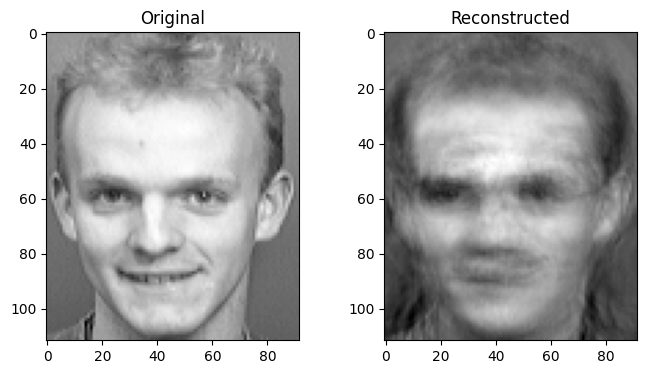

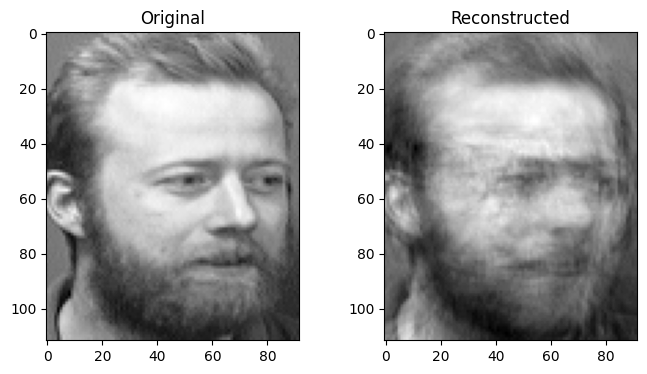

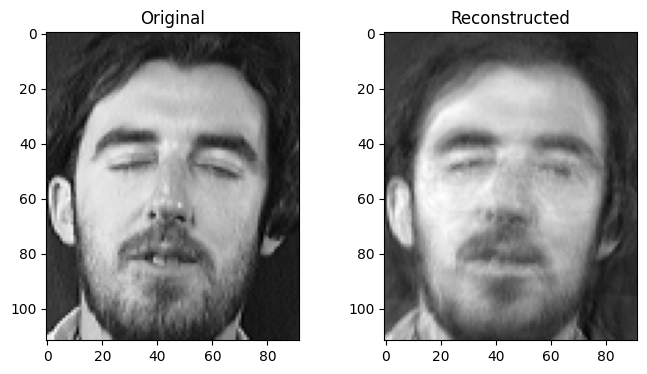

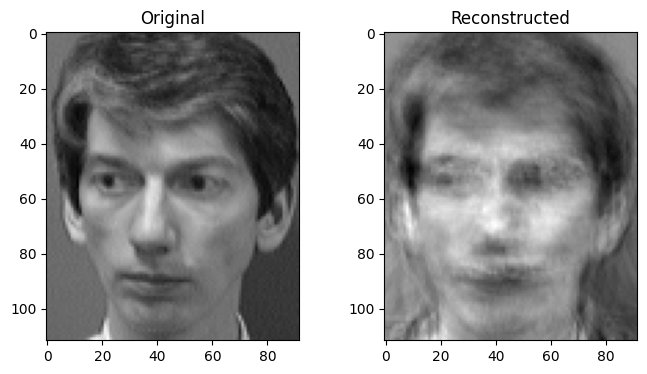

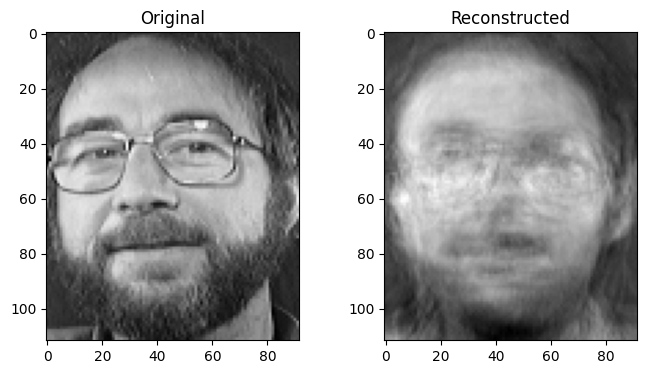

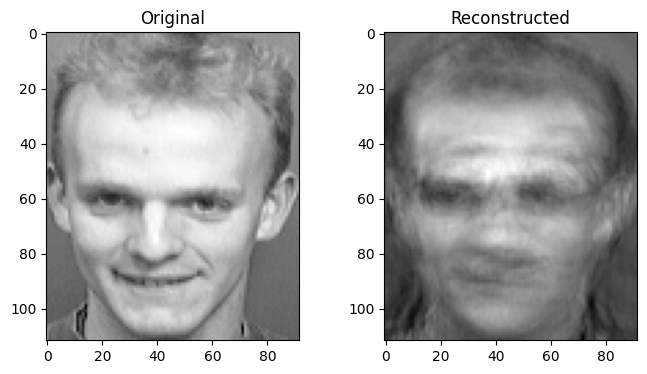

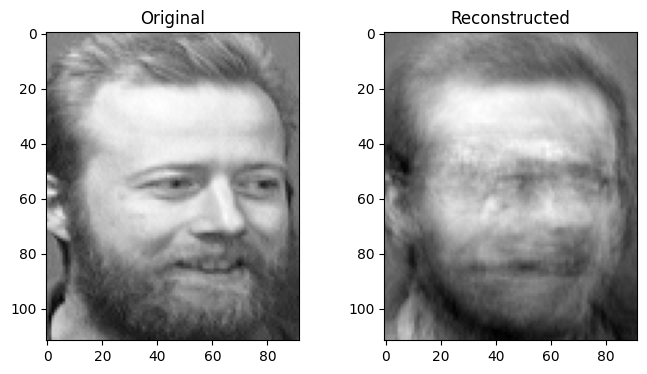

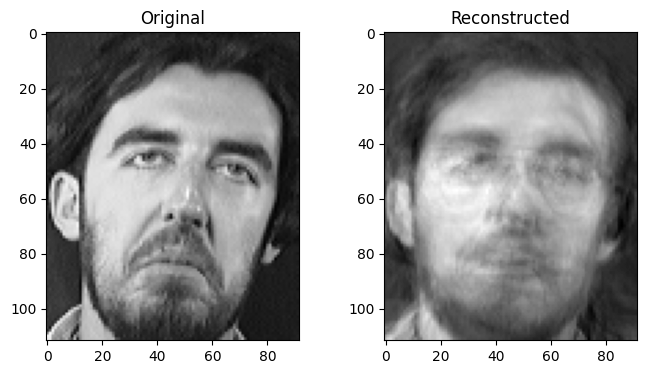

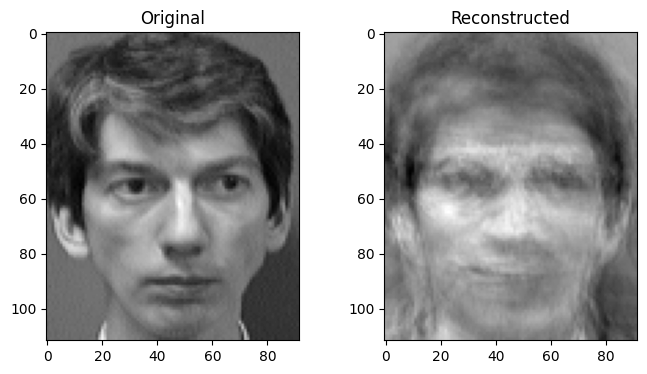

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>$\alpha$ (Retained Variance) = 0.9</center>

## <center>PCA Subspace Dimensions = 76</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

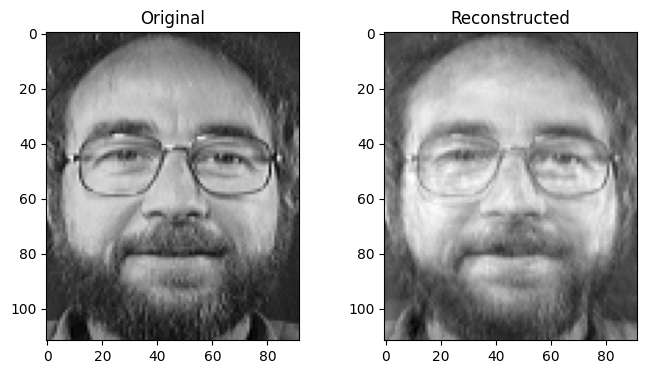

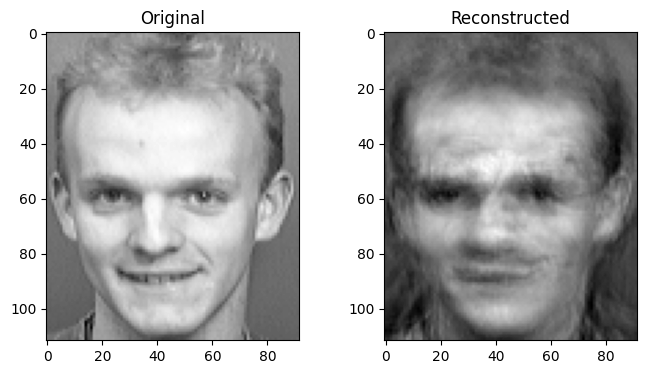

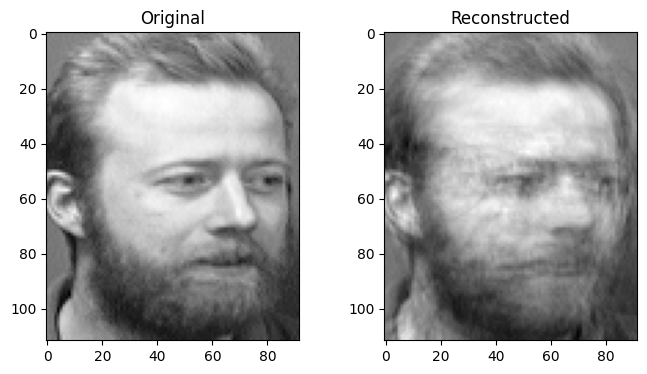

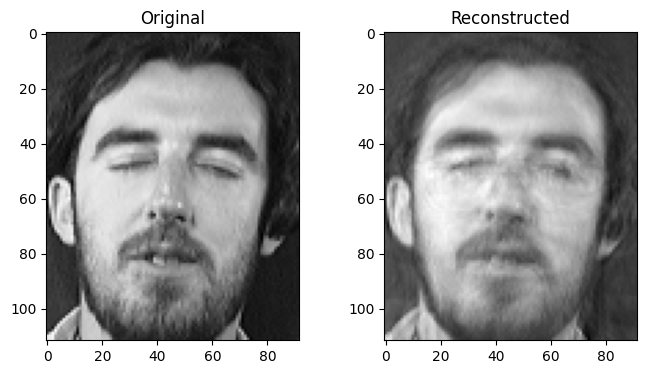

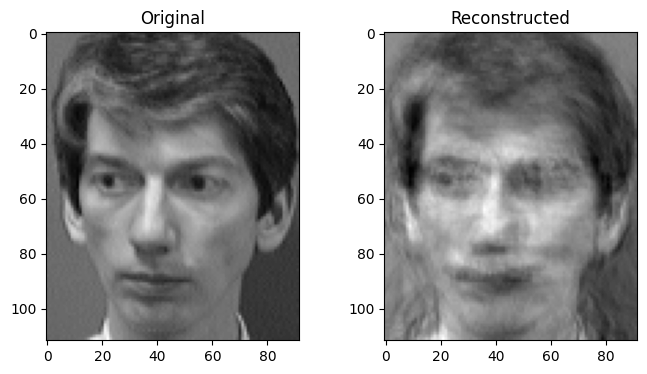

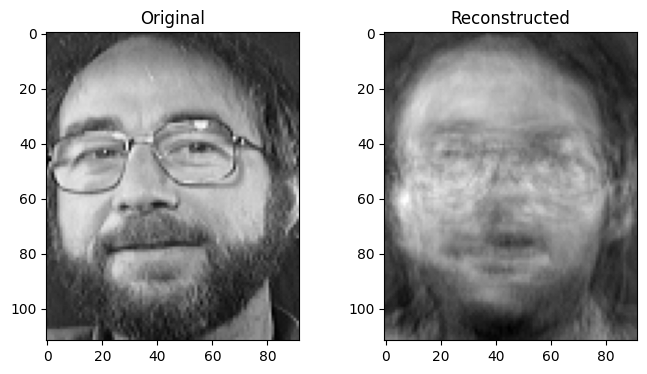

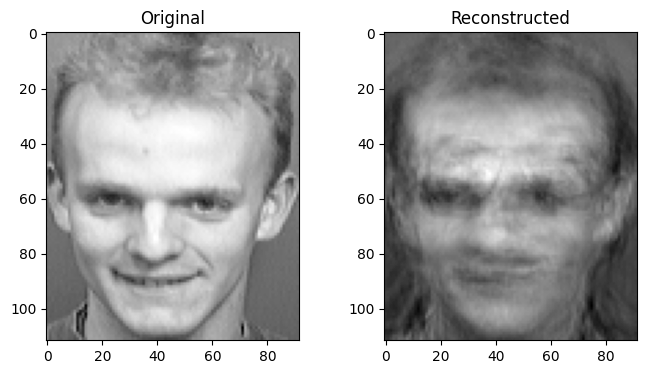

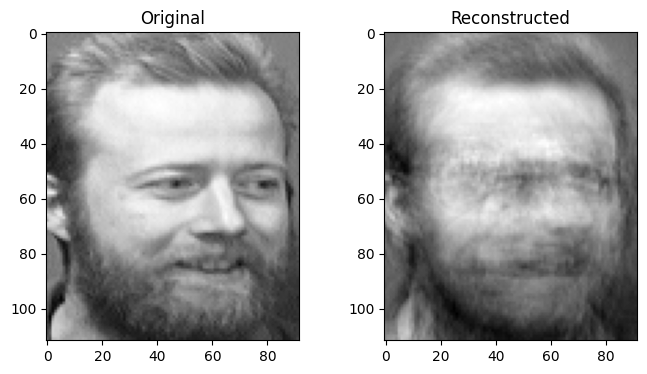

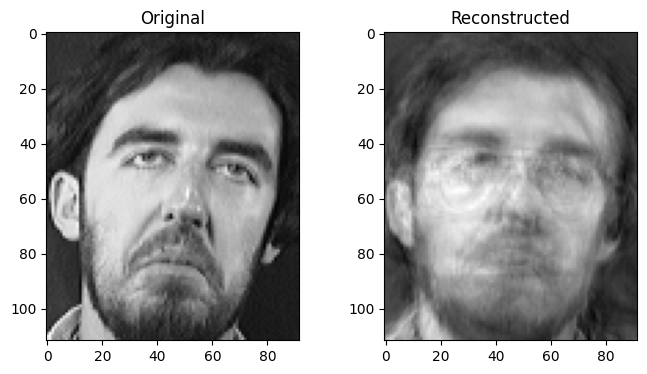

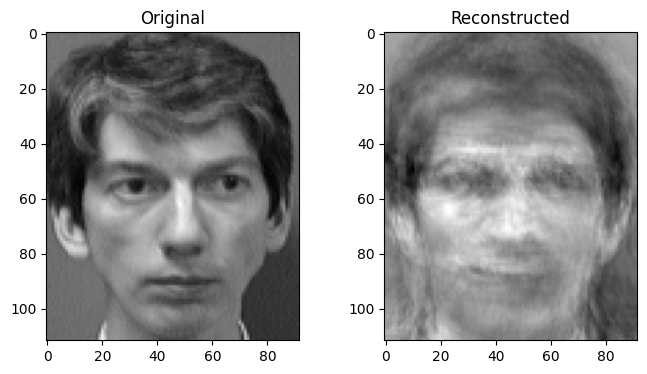

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>$\alpha$ (Retained Variance) = 0.95</center>

## <center>PCA Subspace Dimensions = 117</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

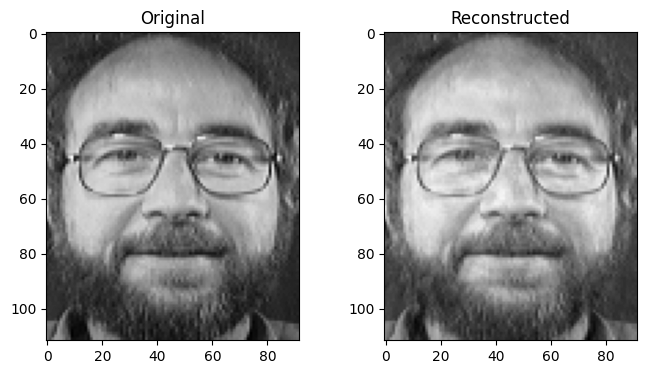

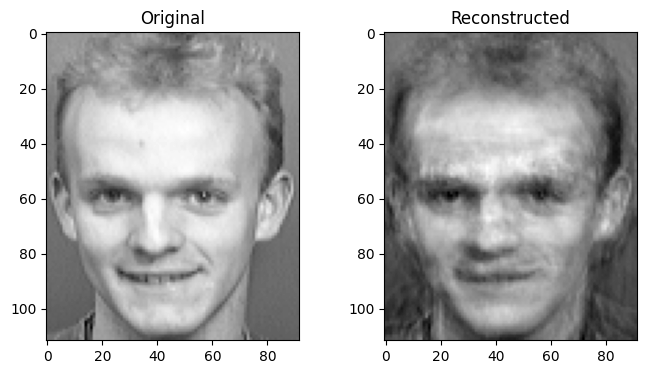

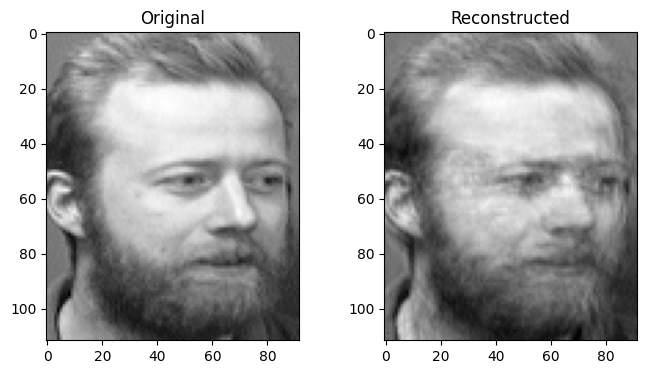

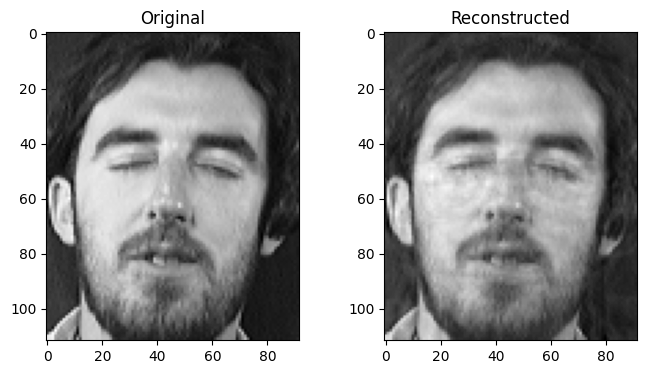

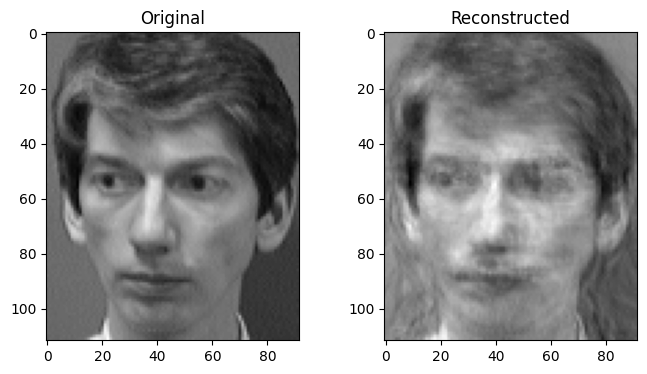

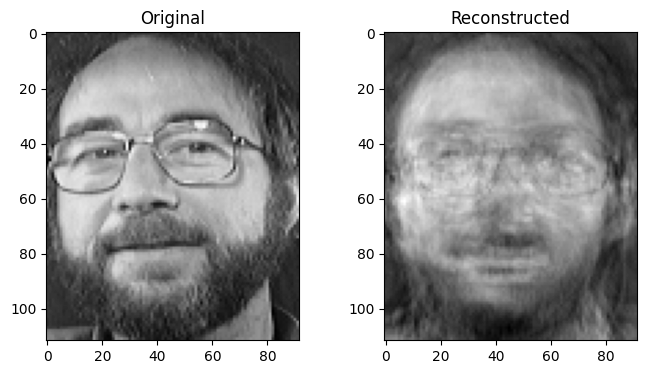

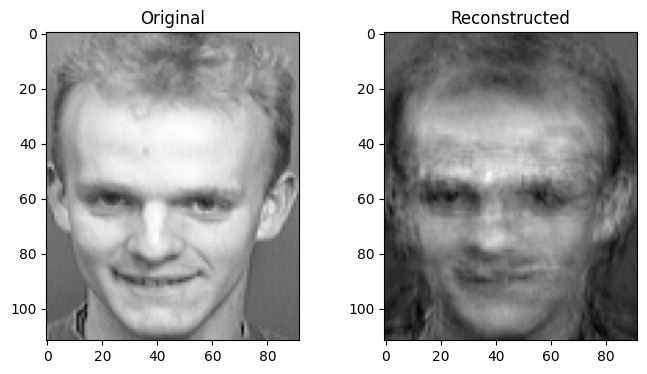

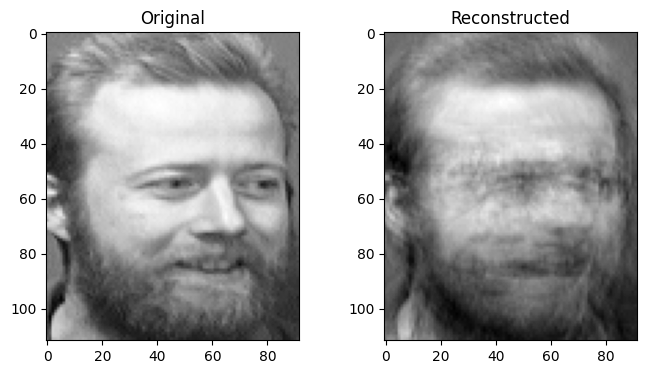

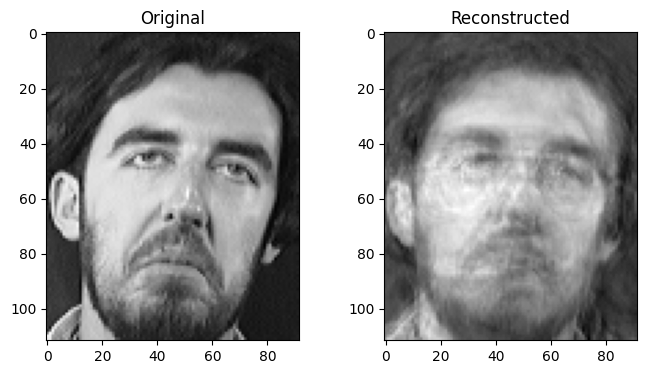

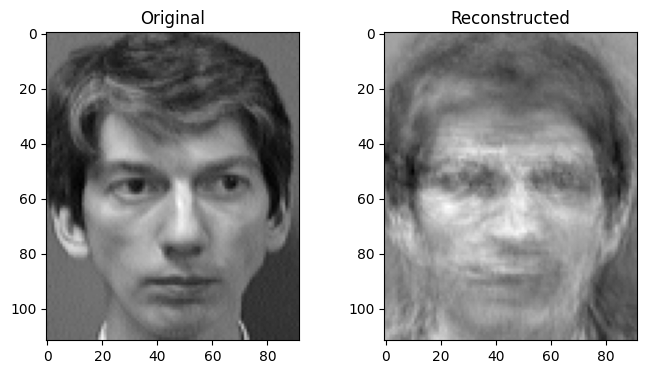

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)


<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

## <center>$\alpha$ (Retained Variance) = 0.99</center>

## <center>PCA Subspace Dimensions = 174</center>

<center><b>━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━</b></center>

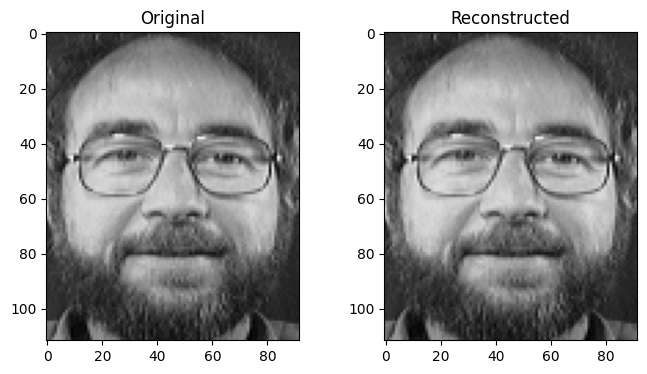

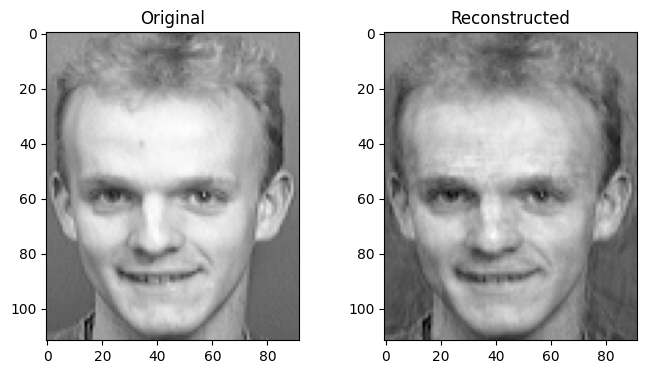

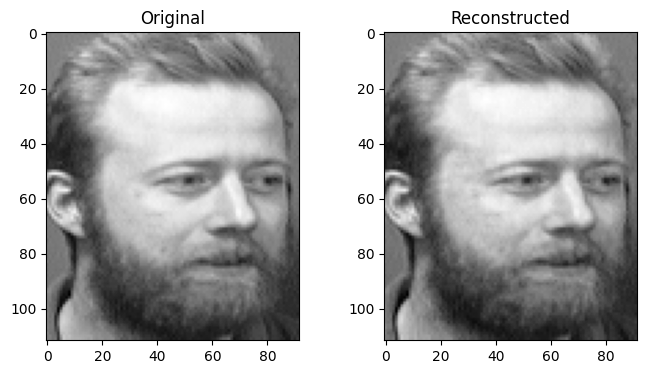

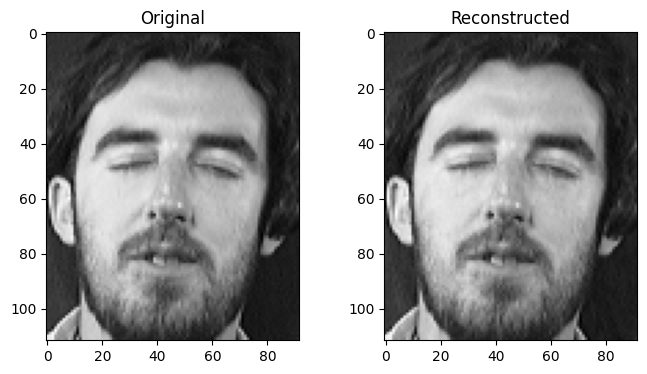

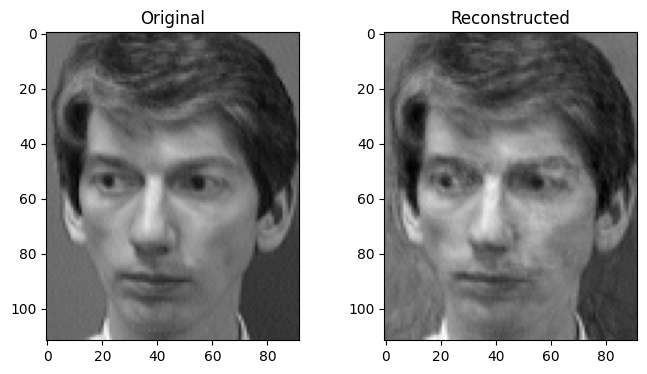

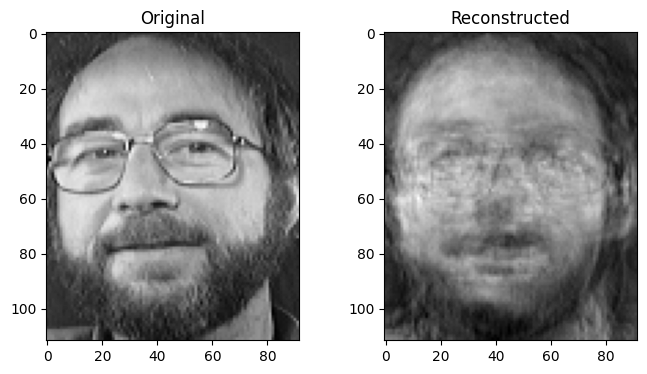

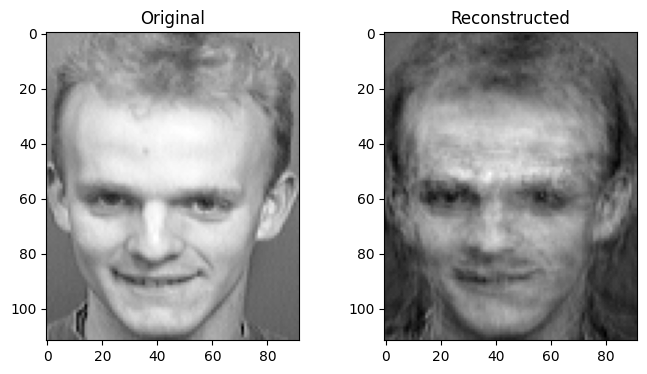

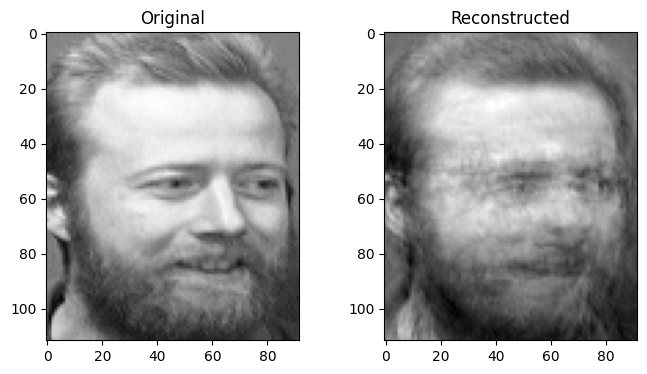

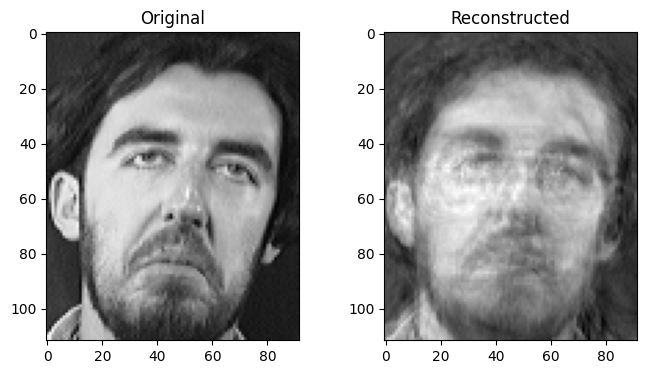

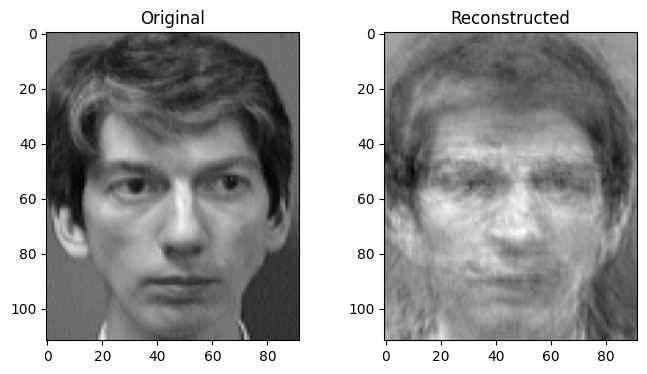

In [26]:
def plot_reconstruction(original_images, reconstructed_images):
    """
    Plotting original vs reconstructed images
    """
    for (original, reconstructed) in zip(original_images, reconstructed_images):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original.reshape(112, 92), cmap='gray')
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed.reshape(112, 92), cmap='gray')
        plt.title("Reconstructed")
        plt.show()

# Values of alpha to be compared
alphas = [0.8, 0.85, 0.9, 0.95, 0.99]
# 5 Random images to explore the effect of changing alpha
random_images = np.random.randint(0, X_train.shape[0]-1, size=5)

# Testing different alpha
for alpha in alphas:
    # Transform into the PCA subspace
    reduced_subspace = PCA(alpha)
    # Project some samples from the training set
    X_train_projected = reduced_subspace.fit_transform(X_train)
    X_train_reconstructed_pca = reduced_subspace.inverse_transform(X_train_projected)
    # Project some samples from the test set
    X_test_projected = reduced_subspace.project(X_test)
    X_test_reconstructed_pca = reduced_subspace.inverse_transform(X_test_projected)
    # Print alpha and subspace dimensionality
    display(Markdown(f"<center><b>{'━'*100}</b></center>"))
    text = Markdown(f'## <center>$\\alpha$ (Retained Variance) = {str(alpha)}</center>')
    dimensionality = Markdown(f'## <center>PCA Subspace Dimensions = {X_train_projected.shape[1]}</center>')
    display(text)
    display(dimensionality)
    display(Markdown(f"<center><b>{'━'*100}</b></center>"))
    # Plot original vs reconstructed images
    plot_reconstruction(X_train[random_images], X_train_reconstructed_pca[random_images])
    plot_reconstruction(X_test[random_images], X_test_reconstructed_pca[random_images])

## K-Means Clustering

### K-Means Impelemntation

In [27]:
def k_means(X, k, max_iterations, tol=1e-4):
    """
    K-Means Clustering Algorithm
    Parameters:
    - X: Input data (n_samples, n_features)
    - k: Number of clusters
    - max_iterations: Maximum number of iterations
    - tol: Tolerance for centroid convergence
    Returns:
    - clusters: List of numpy arrays, each containing points in a cluster
    - centroids: Cluster centroids (k, n_features)
    - cluster_indices: List of lists containing indices of points in each cluster
    """
    X = np.array(X)
    n_samples, size = X.shape

    # Initialize centroids by randomly selecting k points from X
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[indices]
    cluster_indices = []

    for j in range(max_iterations):
        # Initialize clusters for this iteration
        clusters = [[] for _ in range(k)]
        cluster_indices = [[] for _ in range(k)]  # Track indices

        # Assign each point to the nearest centroid
        for idx, x in enumerate(X):
            distances = [np.sqrt(np.sum((x - centroid) ** 2)) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(x)
            cluster_indices[cluster_idx].append(idx)  # Store index

        # Store old centroids for convergence check
        old_centroids = centroids.copy()

        # Update centroids based on mean of each cluster
        new_centroids = []
        for i, cluster in enumerate(clusters):
            if len(cluster) > 0:  # Handle non-empty clusters
                new_centroid = np.mean(np.array(cluster), axis=0)
                new_centroids.append(new_centroid)
            else:  # Handle empty clusters
                # Calculate SSE contribution for each point (distance to its centroid)
                sse_contributions = []
                for idx, x in enumerate(X):
                    distances = [np.sqrt(np.sum((x - centroid) ** 2)) for centroid in centroids]
                    min_distance = min(distances)
                    sse_contributions.append((min_distance ** 2, x))

                # Choose the point with the highest SSE contribution
                _, farthest_point = max(sse_contributions, key=lambda x: x[0])
                new_centroids.append(farthest_point)

        centroids = np.array(new_centroids)
        # print(f'Iteration {j + 1}, new centroids:\n{centroids}')

        # Check for convergence
        if np.allclose(old_centroids, centroids, rtol=0, atol=tol):
            print(f"Converged after {j + 1} iterations!")
            break

    clusters = [np.array(cluster) for cluster in clusters]
    return clusters, centroids, cluster_indices

In [28]:
def compute_accuracy(cluster_indices, y, labels):
    """
    Parameters:
    - cluster_indices: List of lists containing indices of points in each cluster
    - y: True labels
    - labels: Number of unique labels
    Returns:
    - Accuracy of clustering based on majority voting
    """
    m = len(y)
    correct_labels = 0
    k = len(cluster_indices)

    for i in range(k):
        if len(cluster_indices[i]) == 0:  # Skip empty clusters (Note: there will not be empty clusters)
            print('Empty Cluster')
            continue

        # Majority voting for the cluster
        cluster_labels = y[cluster_indices[i]]
        if len(cluster_labels) == 0:
            continue
        major_label = np.bincount(cluster_labels, minlength=labels).argmax()

        # Count correct labels
        correct_labels += np.sum(cluster_labels == major_label)

    return correct_labels / m if m > 0 else 0

### Applying K-Means on the reduced PCA data for each alpha value.

In [29]:
# Values of alpha to be compared
alphas = [0.8, 0.85, 0.9, 0.95, 0.99]
K_values = [20, 40, 60]
accuracies = np.zeros((len(alphas), len(K_values)))

# Testing different alpha
for i, alpha in enumerate(alphas):
    # Transform into the PCA subspace
    reduced_subspace = PCA(alpha)
    X_projected = reduced_subspace.fit_transform(X_train)
    X_reconstructed_pca = reduced_subspace.inverse_transform(X_projected)
    # Testing different K
    for j, k in enumerate(K_values):
        clusters, centroids, cluster_indices = k_means(X_projected, k, max_iterations=100)
        accuracies[i, j] = compute_accuracy(cluster_indices, y_train, len(np.unique(y_train)))
        print(f'K-Means accuracy with alpha={alpha}, K={k}: {accuracies[i, j]}')
        print('------')
    print('------------------------')

Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Converged after 9 iterations!
K-Means accuracy with alpha=0.8, K=20: 0.44
------
Converged after 7 iterations!
K-Means accuracy with alpha=0.8, K=40: 0.67
------
Converged after 7 iterations!
K-Means accuracy with alpha=0.8, K=60: 0.805
------
------------------------
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Converged after 7 iterations!
K-Means accuracy with alpha=0.85, K=20: 0.375
------
Converged after 6 iterations!
K-Means accuracy with alpha=0.85, K=40: 0.595
------
Converged after 4 iterations!
K-Means accuracy with alpha=0.85, K=60: 0.725
------
------------------------
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Converged after 9 iterations!
K-Means accuracy with alpha=0.9, K=20: 0.44
------
Converg

### Evaluate using clustering accuracy.

+---------+--------+--------+--------+
|   Alpha |   K=20 |   K=40 |   K=60 |
+=========+========+========+========+
|  0.8000 | 0.4400 | 0.6700 | 0.8050 |
+---------+--------+--------+--------+
|  0.8500 | 0.3750 | 0.5950 | 0.7250 |
+---------+--------+--------+--------+
|  0.9000 | 0.4400 | 0.6450 | 0.7900 |
+---------+--------+--------+--------+
|  0.9500 | 0.4550 | 0.6250 | 0.7800 |
+---------+--------+--------+--------+
|  0.9900 | 0.3950 | 0.6650 | 0.7900 |
+---------+--------+--------+--------+


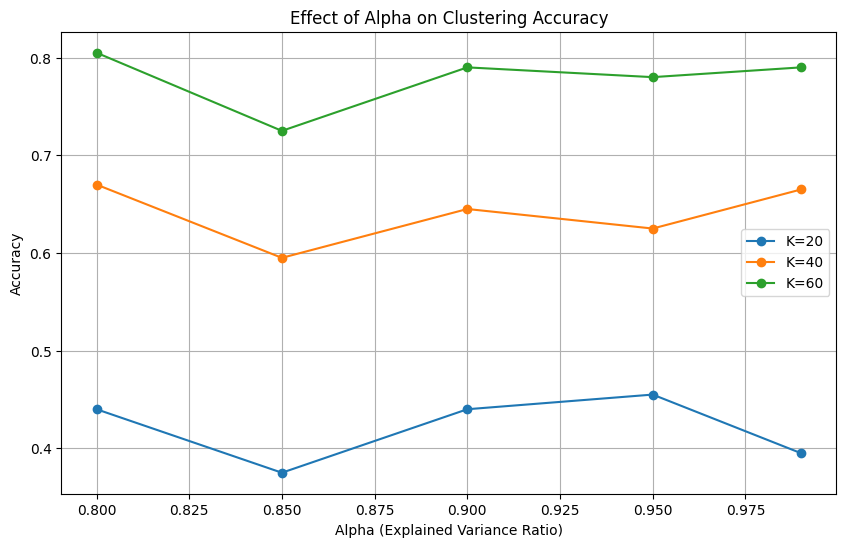

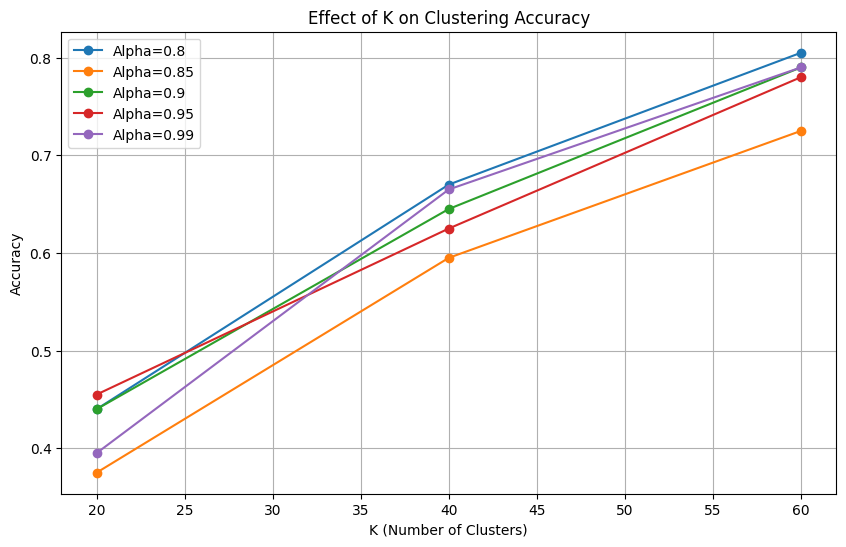

In [30]:
# Prepare table data
table = []
for i, alpha in enumerate(alphas):
    row = [alpha] + list(accuracies[i])
    table.append(row)

# Define headers
headers = ['Alpha'] + [f'K={k}' for k in K_values]

# Print table
print(tabulate(table, headers=headers, tablefmt='grid', floatfmt='.4f'))

# Plot 1: Accuracy vs. Alpha for each K
plt.figure(figsize=(10, 6))
for j, k in enumerate(K_values):
    plt.plot(alphas, accuracies[:, j], marker='o', label=f'K={k}')
plt.xlabel('Alpha (Explained Variance Ratio)')
plt.ylabel('Accuracy')
plt.title('Effect of Alpha on Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Accuracy vs. K for each Alpha
plt.figure(figsize=(10, 6))
for i, alpha in enumerate(alphas):
    plt.plot(K_values, accuracies[i, :], marker='o', label=f'Alpha={alpha}')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Accuracy')
plt.title('Effect of K on Clustering Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Running Best Model on Test Data

In [31]:
def map_cluster_to_labels(cluster_indices, test_cluster_indices, k):
    """
    Maps cluster indices to class labels using majority voting from the training data.

    This function takes clusters formed during unsupervised learning and maps each
    cluster to a class label based on the most frequent label in that cluster from
    the training set. It then predicts labels for test data points based on their
    assigned clusters.

    Parameters:
    -----------
    cluster_indices : list of lists
        A list of k lists, where each inner list contains the indices of training samples
        that belong to a particular cluster.

    test_cluster_indices : list or array
        A list/array containing the cluster assignment (0 to k-1) for each test sample.

    k : int
        The number of clusters.

    Returns:
    --------
    test_pred_labels : list
        Predicted labels for the test samples based on their cluster assignments.

    Notes:
    ------
    - Uses y_train from the global scope to determine the majority label in each cluster
    - Empty clusters are assigned a default label of 0
    - Assumes cluster indices are 0-indexed (0 to k-1)
    """
    cluster_labels = []
    for i in range(k):
        if len(cluster_indices[i]) == 0:
            cluster_labels.append(0)  # Default for empty clusters
            continue
        cluster_train_labels = y_train[cluster_indices[i]]
        major_label = np.bincount(cluster_train_labels, minlength=len(np.unique(y_train))).argmax()
        cluster_labels.append(major_label)
    test_pred_labels = [cluster_labels[idx] for idx in test_cluster_indices]

    return test_pred_labels

In [32]:
def find_best_model(accuracies, alphas, K_values):
    """
    Identifies the best model hyperparameters from a grid search.

    Parameters:
    -----------
    accuracies : ndarray
        2D array of accuracy scores for each hyperparameter combination.
    alphas : array-like
        List of alpha values (PCA dimensions) evaluated.
    K_values : array-like
        List of K values (number of clusters) evaluated.

    Returns:
    --------
    tuple
        (best_alpha, best_k, best_accuracy) containing the optimal hyperparameters
        and corresponding accuracy.
    """
    best_idx = np.unravel_index(np.argmax(accuracies), accuracies.shape)
    best_alpha = alphas[best_idx[0]]
    best_k = K_values[best_idx[1]]
    best_accuracy = accuracies[best_idx]

    return best_alpha, best_k, best_accuracy

In [33]:
def assign_test_samples_to_clusters(X_test_projected, centroids):
    """
    Assigns each test point to the nearest cluster.

    Parameters:
    -----------
    X_test_projected : ndarray
        Test data projected into PCA subspace.
    centroids : ndarray
        Cluster centroids from K-means.

    Returns:
    --------
    list
        Cluster assignments for each test sample.
    """
    test_cluster_indices = []
    for x in X_test_projected:
        distances = [np.sqrt(np.sum((x - centroid) ** 2)) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        test_cluster_indices.append(cluster_idx)

    return test_cluster_indices

In [34]:
def find_best_model(accuracies, alphas, K_values):
    """
    Identifies the best model hyperparameters from a grid search.

    Parameters:
    -----------
    accuracies : ndarray
        2D array of accuracy scores for each hyperparameter combination.
    alphas : array-like
        List of alpha values (PCA dimensions) evaluated.
    K_values : array-like
        List of K values (number of clusters) evaluated.

    Returns:
    --------
    tuple
        (best_alpha, best_k, best_accuracy) containing the optimal hyperparameters
        and corresponding accuracy.
    """
    best_idx = np.unravel_index(np.argmax(accuracies), accuracies.shape)
    best_alpha = alphas[best_idx[0]]
    best_k = K_values[best_idx[1]]
    best_accuracy = accuracies[best_idx]

    return best_alpha, best_k, best_accuracy

In [35]:
def assign_test_samples_to_clusters(X_test_projected, centroids):
    """
    Assigns each test point to the nearest cluster.

    Parameters:
    -----------
    X_test_projected : ndarray
        Test data projected into PCA subspace.
    centroids : ndarray
        Cluster centroids from K-means.

    Returns:
    --------
    list
        Cluster assignments for each test sample.
    """
    test_cluster_indices = []
    for x in X_test_projected:
        distances = [np.sqrt(np.sum((x - centroid) ** 2)) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        test_cluster_indices.append(cluster_idx)

    return test_cluster_indices

In [36]:
def plot_confusion_matrix(y_true, y_pred, num_classes, filename='confusion_matrix.png'):
    """
    Creates and saves a confusion matrix visualization.

    Parameters:
    -----------
    y_true : array-like
        True labels.
    y_pred : array-like
        Predicted labels.
    num_classes : int
        Number of classes in the dataset.
    filename : str, optional
        Filename to save the confusion matrix plot.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
                xticklabels=np.arange(num_classes),
                yticklabels=np.arange(num_classes))

    plt.title('Confusion Matrix for K-Means Clustering (Test Set)', fontsize=14)
    plt.xlabel('Predicted Subject ID', fontsize=12)
    plt.ylabel('True Subject ID', fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename)

In [37]:
def evaluate_model(X_train, X_test, y_train, y_test, alphas, K_values, accuracies):
    """
    Evaluates the best model identified from grid search on the test set.

    Parameters:
    -----------
    X_train : ndarray
        Training feature data.
    X_test : ndarray
        Test feature data.
    y_train : ndarray
        Training labels.
    y_test : ndarray
        Test labels.
    alphas : array-like
        List of alpha values (PCA dimensions) evaluated.
    K_values : array-like
        List of K values (number of clusters) evaluated.
    accuracies : ndarray
        2D array of accuracy scores for each hyperparameter combination.

    Returns:
    --------
    dict
        Dictionary containing test metrics and best hyperparameters.
    """
    # Find best model hyperparameters
    best_alpha, best_k, best_accuracy = find_best_model(accuracies, alphas, K_values)
    print(f"Best model: alpha={best_alpha}, K={best_k}, Training Accuracy={best_accuracy:.4f}")

    # Re-run PCA with best parameters
    reduced_subspace = PCA(best_alpha)
    X_train_projected = reduced_subspace.fit_transform(X_train)
    X_test_projected = reduced_subspace.project(X_test)

    # Run K-means with best parameters
    clusters, centroids, cluster_indices = k_means(X_train_projected, best_k, max_iterations=100)

    # Assign test points to clusters
    test_cluster_indices = assign_test_samples_to_clusters(X_test_projected, centroids)

    # Map clusters to labels and predict test labels
    test_pred_labels = map_cluster_to_labels(cluster_indices, test_cluster_indices, best_k)

    # Calculate performance metrics
    test_accuracy = np.sum(test_pred_labels == y_test) / len(y_test)
    test_f1 = f1_score(y_test, test_pred_labels, average='weighted')

    # Print results
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    # Plot confusion matrix
    num_classes = len(np.unique(y_train))
    plot_confusion_matrix(y_test, test_pred_labels, num_classes, 'confusion_matrix_kmeans.png')

    return {
        'best_alpha': best_alpha,
        'best_k': best_k,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
    }

Best model: alpha=0.8, K=60, Training Accuracy=0.8050
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Converged after 6 iterations!
Test Accuracy: 0.7150
Test F1-Score: 0.6706


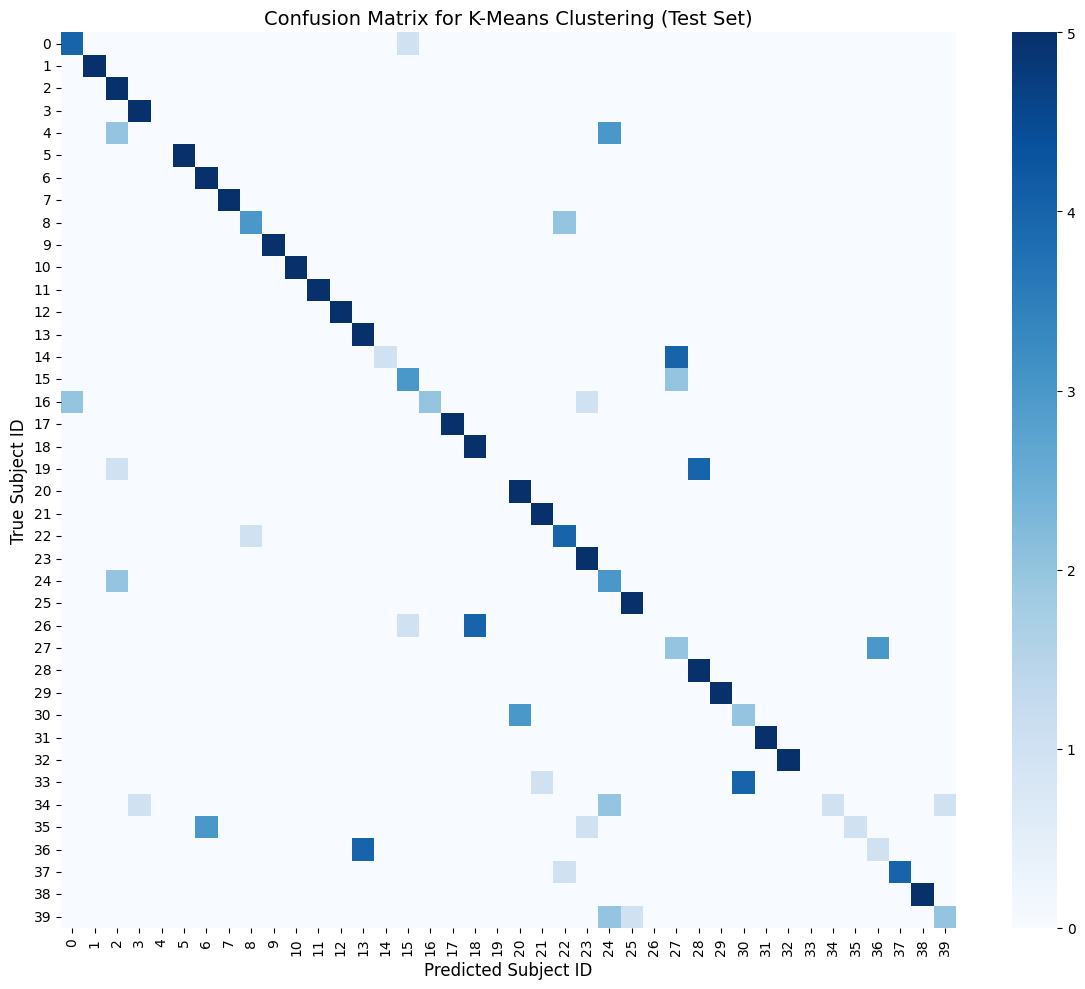

In [38]:
k_means_results = evaluate_model(X_train, X_test, y_train, y_test, alphas, K_values, accuracies)

# Gaussian Mixture Model Clustering

## Implementation

In [39]:
from scipy.special import logsumexp

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        """
        Initialize the Gaussian Mixture Model.

        Parameters:
        - n_components: int, number of mixture components (clusters).
        - max_iter: int, maximum number of EM iterations.
        - tol: float, convergence threshold for log-likelihood improvement.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihood_history = []

    def initialize_parameters(self, X):
        """
        Initialize the model parameters.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the data matrix.

        Initializes means using random selection, covariances as identity matrices,
        and equal weights for each component.
        """
        n_samples, n_features = X.shape
        # Randomly select initial means from data points
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]
        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        # Initialize weights equally
        self.weights = np.ones(self.n_components) / self.n_components

    def expectation_step(self, X):
        """
        Perform the E-step with log-domain computation (numerically stable).

        Parameters:
        - X: numpy array, shape (n_samples, n_features)

        Returns:
        - responsibilities: numpy array, shape (n_samples, n_components)
        """
        n_samples = X.shape[0]
        log_responsibilities = np.zeros((n_samples, self.n_components))

        # Compute log responsibilities
        for k in range(self.n_components):
            log_responsibilities[:, k] = np.log(self.weights[k] + 1e-10) + multivariate_normal.logpdf(
                X, mean=self.means[k], cov=self.covariances[k], allow_singular=True
            )

        # normalize with log-sum-exp
        log_sum = logsumexp(log_responsibilities, axis=1, keepdims=True)
        responsibilities = np.exp(log_responsibilities - log_sum)
        return responsibilities

    def maximization_step(self, X, responsibilities):
        """
        Perform the M-step: update model parameters.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the data matrix.
        - responsibilities: numpy array, shape (n_samples, n_components),
          the responsibilities from the E-step.
        """
        n_samples, n_features = X.shape
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum()
            # Update means
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
            # Update covariances
            diff = X - self.means[k]
            self.covariances[k] = (resp_k[:, np.newaxis] * diff).T.dot(diff) / total_resp
            # Regularize covariance to avoid singularity
            self.covariances[k] += 1e-6 * np.eye(n_features)
            # Update weights
            self.weights[k] = total_resp / n_samples

    def compute_log_likelihood(self, X):
        """
        Compute the log-likelihood of the data under the current model.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the data matrix.

        Returns:
        - log_likelihood: float, the log-likelihood.
        """
        log_probs = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            log_probs[:, k] = (
                np.log(self.weights[k] + 1e-10)
                + multivariate_normal.logpdf(X, mean=self.means[k], cov=self.covariances[k], allow_singular=True)
            )
        sample_ll = logsumexp(log_probs, axis=1)
        return sample_ll.sum()

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the data matrix.
        """
        self.initialize_parameters(X)
        prev_log_likelihood = None
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.expectation_step(X)
            # M-step
            self.maximization_step(X, responsibilities)
            # Compute log-likelihood
            log_likelihood = self.compute_log_likelihood(X)
            # Check for convergence
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        """
        Predict the cluster assignments for the data points.

        Parameters:
        - X: numpy array, shape (n_samples, n_features), the data matrix.

        Returns:
        - labels: numpy array, shape (n_samples,), the cluster assignments.
        """
        responsibilities = self.expectation_step(X)
        labels = np.argmax(responsibilities, axis=1)
        return labels


## Evaluation

In [40]:
def match_clusters_to_labels(clusters, true_labels, K):
    predicted_labels = np.zeros_like(true_labels)
    for cluster_id in range(K):
        cluster_indices = np.where(clusters == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
        true_labels_in_cluster = true_labels[cluster_indices]
        most_common_label = np.bincount(true_labels_in_cluster).argmax()
        predicted_labels[cluster_indices] = most_common_label
    return predicted_labels

Running PCA with alpha = 0.8...
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Number of PCA components: 36
Running GMM with K = 20...
Running GMM with K = 40...
Running GMM with K = 60...
Running PCA with alpha = 0.85...
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Number of PCA components: 52
Running GMM with K = 20...
Running GMM with K = 40...
Running GMM with K = 60...
Running PCA with alpha = 0.9...
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Number of PCA components: 76
Running GMM with K = 20...
Running GMM with K = 40...
Running GMM with K = 60...
Running PCA with alpha = 0.95...
Eigenvalues and eigenvectors are already saved.
Number of eigenvalues: (10304,)
Principal components shape: (10304, 10304)
Number of PCA components: 117
Running GMM with K

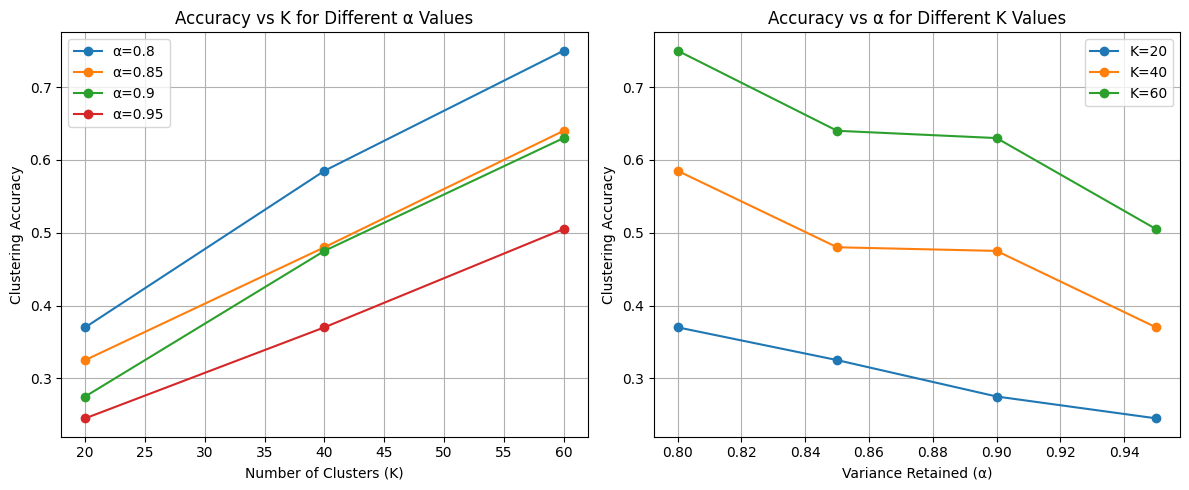


Results Table:
α	K	Accuracy
0.80	20	0.3700
0.80	40	0.5850
0.80	60	0.7500
0.85	20	0.3250
0.85	40	0.4800
0.85	60	0.6400
0.90	20	0.2750
0.90	40	0.4750
0.90	60	0.6300
0.95	20	0.2450
0.95	40	0.3700
0.95	60	0.5050

Evaluating Best Model (α=0.8, K=60) on Test Set:
Accuracy: 0.7650
F1-Score: 0.7414

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 0]]


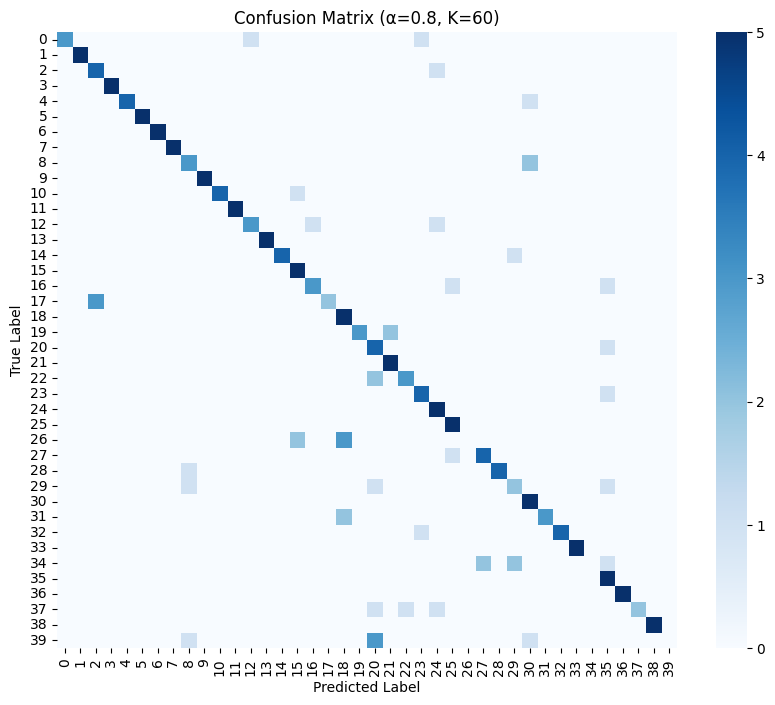

In [41]:
# List to store results
results = []
alpha_values = [0.8, 0.85, 0.9, 0.95]
K_values = [20, 40, 60]

# Store models for the best configuration
best_model = {'accuracy': 0, 'alpha': None, 'K': None, 'pca': None, 'scaler': None, 'gmm': None}

# Loop over alpha values (variance thresholds)
for alpha in alpha_values:
    print(f"Running PCA with alpha = {alpha}...")

    # Apply PCA with given alpha
    pca = PCA(alpha)
    X_train_projected = pca.fit_transform(X_train)

    # Scale the projected data
    scaler = StandardScaler()
    X_train_projected = scaler.fit_transform(X_train_projected)

    # Print number of components for reference
    print(f"Number of PCA components: {X_train_projected.shape[1]}")

    # Loop over different K values (clusters)
    for K in K_values:
        print(f"Running GMM with K = {K}...")

        # Initialize and fit GMM
        gmm = GMM(n_components=K)
        gmm.fit(X_train_projected)

        # Predict clusters on test data
        clusters = gmm.predict(X_train_projected)

        # Map clusters to true labels
        matched_labels = match_clusters_to_labels(clusters, y_train, K)

        # Calculate accuracy
        acc = accuracy_score(y_train, matched_labels)

        # Save (alpha, K, accuracy) for analysis
        results.append((alpha, K, acc))

        # Update best model if current accuracy is higher
        if acc > best_model['accuracy']:
            best_model.update({
                'accuracy': acc,
                'alpha': alpha,
                'K': K,
                'pca': pca,
                'scaler': scaler,
                'gmm': gmm
            })

# Convert results to numpy array
results = np.array(results)

# Plot results
plt.figure(figsize=(12, 5))

# Accuracy vs K
plt.subplot(1, 2, 1)
for alpha in alpha_values:
    alpha_results = results[results[:, 0] == alpha]
    plt.plot(alpha_results[:, 1], alpha_results[:, 2], marker='o', label=f'α={alpha}')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Clustering Accuracy")
plt.title("Accuracy vs K for Different α Values")
plt.legend()
plt.grid(True)

# Accuracy vs alpha
plt.subplot(1, 2, 2)
for K in K_values:
    K_results = results[results[:, 1] == K]
    plt.plot(K_results[:, 0], K_results[:, 2], marker='o', label=f'K={K}')
plt.xlabel("Variance Retained (α)")
plt.ylabel("Clustering Accuracy")
plt.title("Accuracy vs α for Different K Values")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Tabulate results
print("\nResults Table:")
print("α\tK\tAccuracy")
for alpha, K, acc in results:
    print(f"{alpha:.2f}\t{int(K)}\t{acc:.4f}")

# Evaluate the best model on the test set
print(f"\nEvaluating Best Model (α={best_model['alpha']}, K={best_model['K']}) on Test Set:")
clusters = best_model['gmm'].predict(best_model['scaler'].transform(best_model['pca'].project(X_test)))
matched_labels = match_clusters_to_labels(clusters, y_test, best_model['K'])
best_acc = accuracy_score(y_test, matched_labels)
best_f1 = f1_score(y_test, matched_labels, average='macro')
best_cm = confusion_matrix(y_test, matched_labels)

print(f"Accuracy: {best_acc:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print("\nConfusion Matrix:")
print(best_cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(best_cm, annot=False, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (α={best_model["alpha"]}, K={best_model["K"]})')
plt.show()


## Autoencoder

### Autoencoder Impelementaion

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0381 - val_loss: 0.0283
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0253 - val_loss: 0.0286
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0243 - val_loss: 0.0264
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0227 - val_loss: 0.0255
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0228 - val_loss: 0.0263
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0215 - val_loss: 0.0246
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0203 - val_loss: 0.0267
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0190 - val_loss: 0.0248
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0187 - val_loss: 0.0255
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0185 - val_loss: 0.0252
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0176 - val_loss: 0.0261
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0170 - val_loss: 0.0247


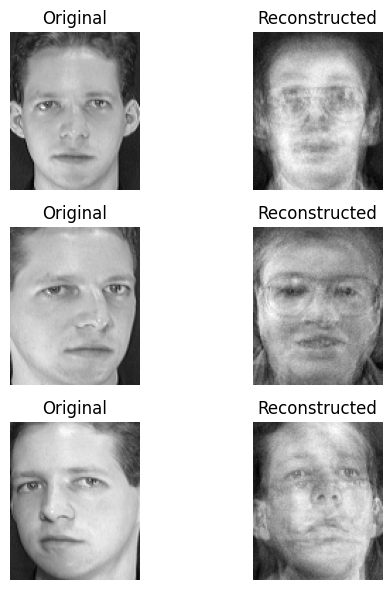

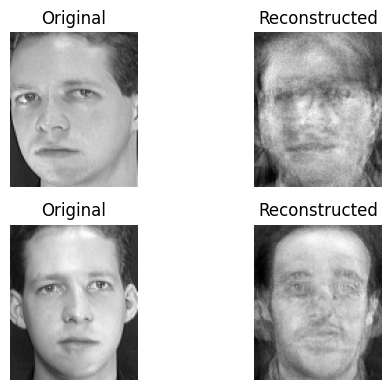

In [42]:
# Normalize input data
X_train = X_train / 255.0
X_test = X_test / 255.0

# 1. Define the Autoencoder
input_dim = 10304  # 112 * 92
latent_dim = 128

# Build the autoencoder model
input_layer = keras.Input(shape=(input_dim,))
# Encoder
encoded = layers.Dense(512, activation='relu')(input_layer)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)
# Decoder
decoded = layers.Dense(256, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)  # Separate encoder model for latent representations

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
num_epochs = 50
batch_size = 32
history = autoencoder.fit(
    X_train, X_train,  # Input and target are the same
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# Print loss every 10 epochs
for epoch in range(0, num_epochs, 10):
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {history.history['loss'][epoch]:.4f}")

# 2. Get reduced representations
train_encoded = encoder.predict(X_train)
test_encoded = encoder.predict(X_test)

# 3. Visualize original vs reconstructed images
n_total = 5  # Total number of samples to visualize
samples_per_figure = 3  # Number of samples per figure
num_figures = (n_total + samples_per_figure - 1) // samples_per_figure  # Ceiling division

# Get reconstructed images
reconstructed = autoencoder.predict(X_test[:n_total])

# Create multiple figures
for fig_idx in range(num_figures):
    start_idx = fig_idx * samples_per_figure
    end_idx = min(start_idx + samples_per_figure, n_total)
    n = end_idx - start_idx  # Number of samples in this figure

    plt.figure(figsize=(6, 2 * n))  # Width: 6 inches, Height: 2 inches per sample
    for i in range(n):
        global_idx = start_idx + i
        # Original
        ax = plt.subplot(n, 2, 2 * i + 1)  # First column of row i
        plt.imshow(X_test[global_idx].reshape(112, 92), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        # Reconstructed
        ax = plt.subplot(n, 2, 2 * i + 2)  # Second column of row i
        plt.imshow(reconstructed[global_idx].reshape(112, 92), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'autoencoder_reconstructed_{fig_idx + 1}.png')
    plt.show()

## Evaluating K-Means and GMM on autoencoder reduced space

In [43]:
# 4. K-Means clustering on reduced representations
clusters, centroids, cluster_indices = k_means(train_encoded, k_means_results['best_k'], max_iterations=100)

accuracy = compute_accuracy(cluster_indices, y_train, k_means_results['best_k'])
print(f'Accuracy of K-Means on autoencoder reduced space: {accuracy:.4f}')

test_cluster_indices = assign_test_samples_to_clusters(test_encoded, centroids)
test_pred_labels = map_cluster_to_labels(cluster_indices, test_cluster_indices, k_means_results['best_k'])

# Calculate performance metrics
test_accuracy = accuracy_score(y_test, test_pred_labels)
test_f1 = f1_score(y_test, test_pred_labels, average='weighted')

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# 5. GMM on reduced representations
scaler = StandardScaler()
train_encoded_scaled = scaler.fit_transform(train_encoded)
test_encoded_scaled = scaler.transform(test_encoded)

gmm = GMM(n_components= best_model['K'])
gmm.fit(train_encoded_scaled)
gmm_clusters = gmm.predict(train_encoded_scaled)

# Match GMM clusters to true labels
gmm_matched_labels = match_clusters_to_labels(gmm_clusters, y_train,best_model['K'])
gmm_accuracy = accuracy_score(y_train, gmm_matched_labels)
print(f'Accuracy of GMM on autoencoder reduced space: {gmm_accuracy:.4f}')

clusters = gmm.predict(test_encoded_scaled)
test_cluster_indices = assign_test_samples_to_clusters(test_encoded, centroids)
test_matched_labels = match_clusters_to_labels(clusters, y_test, best_model['K'])
best_acc = accuracy_score(y_test, test_matched_labels)
best_f1 = f1_score(y_test, matched_labels, average='macro')

print(f"Test Accuracy: {best_acc:.4f}")
print(f"Test F1-Score: {best_f1:.4f}")

Converged after 10 iterations!
Accuracy of K-Means on autoencoder reduced space: 0.7400
Test Accuracy: 0.6650
Test F1-Score: 0.6159
Accuracy of GMM on autoencoder reduced space: 0.7550
Test Accuracy: 0.6400
Test F1-Score: 0.7414
